In [55]:
%load_ext autoreload
%autoreload 2

## Shapley value defintion
Given a set of n elements, $U := \{1, \cdots, n\}$ and a function

$g: 2^U \rightarrow \mathbb{R}$ with $g(U) \neq 0$, $g(\varnothing)=0$

define $C(j|T) := g(T \cup \{j\}) - g(T)$ with $T \subseteq U$.

Feture i's contribution:

$\phi_i := \sum_{T \subseteq U} \frac{|T|! (n-1-|T|)!}{n!} C(i|T)$

where
$g(T) := f_T(x_T) - f(x')$ with $f_\varnothing(x_\varnothing) = f(x')$ for some baseline $x'$. 

$f_T(x_T) := \mathbb{E}[ f(x_T, X_{\bar{T}}) | z]$  where $z$ is a hyperparameter

previous approaches considers
- unconditional: $z := \varnothing$
- conditional: $z := \{X_T = x_T \}$

we in addition consider using a causal graph
- do: $z := \{do(X_T = x_T)\}$

## Assumptions
- no unobserved confounders

## Hyper parameters
- dropped_feature_imputation: unconditional, conditional, do 
- timelines: all, last (permutation importance), valid

In [209]:
import networkx as nx
import numpy as np
import matplotlib.image as mpimg
from IPython.display import Image
import matplotlib.pyplot as plt
from flow import main, Node, CreditFlow, check_baseline_target, Graph

# Sanity check with linear models

In [230]:
def build_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph: x1->x2, y = x1 + x2
    x1 = Node('x1')
    x2 = Node('x2', lambda x1: x1, [x1])
    y  = Node('target', lambda x1, x2: x1 + x2, [x1, x2], is_target_node=True)

    # initialize the values from data: now is just specified
    graph = Graph([x1, x2, y], 
              # sample baseline
              lambda: {'x1': 0, 'x2': 0, 'target': 0},
              # target to explain
              {'x1': 1, 'x2': 1.5, 'target': 2.5})

    # check the amount of noise
    check_baseline_target(graph)
    return graph

cf = CreditFlow(verbose=True, nruns=1, permute_edges=True, noise_self_loop=True)
graph = build_graph()
cf.run(graph)

outcome additive noise for x2 is 0.5
using order [x1, x2, target]
baselines x1: 0, x2: 0, target: 0
turn on node x1 form 0 to 1
turn on edge x1->target
target changes from 0 to 1
assign 1 credits to x1->target
assign 1 credits to x1_noise->x1
turn on edge x1->x2
x2 changes from 0 to 1
turn on edge x2->target
target changes from 1 to 2
assign 1 credits to x2->target
assign 1 credits to x1->x2
assign 1 credits to x1_noise->x1
turn on node x2 form 1 to 1.5
turn on edge x2->target
target changes from 2 to 2.5
assign 0.5 credits to x2->target
assign 0.5 credits to x2_noise->x2
turn on node target form 2.5 to 2.5
assign 0.0 credits to target_noise->target


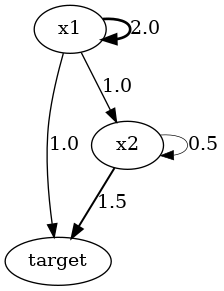

In [231]:
dot = cf.credit2dot()
dot.write_png('graph.png')
Image('graph.png')

In this example, [x1, x2, target] is the only valid timeline. However, there are 2 paths to the output.

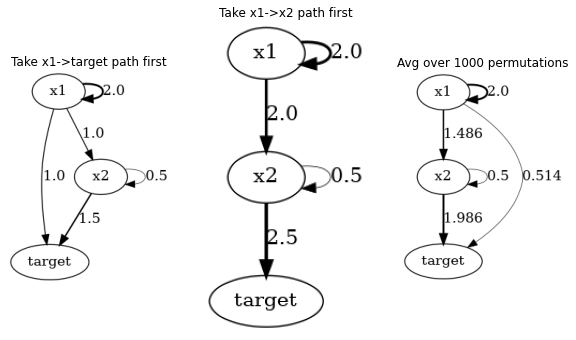

In [141]:
plt.figure(figsize=(10, 6))
plt.subplot(1,3,1)
plt.title('Take x1->target path first')
plt.imshow(mpimg.imread('figures/graph_correct_order.png'))
plt.axis('off')
plt.subplot(1,3,2)
plt.title('Take x1->x2 path first')
plt.imshow(mpimg.imread('figures/graph_wrong_order.png'))
plt.axis('off')
plt.subplot(1,3,3)
plt.title('Avg over 1000 permutations')
plt.imshow(mpimg.imread('figures/graph_avg_order.png'))
plt.axis('off')
plt.show()

**Observation**: we shouldn't permute the order of edges in this graph because only one order corresponds to intervention in linear models (also corresponds to the ordering of DeepLift and IG).
The correct order is [y, x1, x2] in this case.

This fixation of order significantly reduces our computational cost (because the number of path could be near exponential, now we just have 1 for each timeline).

Below we show running this algorithm for a more complicated graph. **Which representation is clearer?** Noise as self loop vs not

outcome additive noise for x2 is 0.5
outcome additive noise for x3 is -0.5
outcome additive noise for x2 is 0.5
outcome additive noise for x3 is -0.5


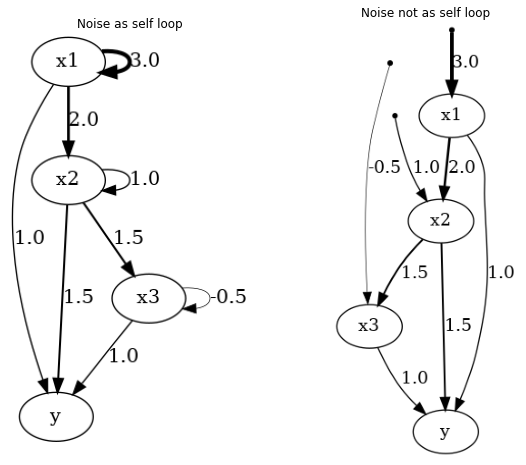

In [214]:
def build_graph2():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph: x1->x2->x3, y = f(x1, x2, x3)
    x1 = Node('x1')
    x2 = Node('x2', lambda x1: x1, [x1])
    x3 = Node('x3', lambda x2: x2, [x2])
    y  = Node('y', lambda x1, x2, x3: x1 + x2 + x3, [x1, x2, x3], 
              is_target_node=True)

    # initialize the values from data
    graph = Graph([x1, x2, x3, y], 
                  # sample baseline
                  lambda: {'x1': 0, 'x2': 0, 'x3': 0, 'y': 0},
                  # target to explain
                  {'x1': 1, 'x2': 1.5, 'x3': 1, 'y': 3.5})

    # check the amount of noise
    check_baseline_target(graph)
    return graph

cf = CreditFlow(verbose=False, nruns=1, noise_self_loop=True)
graph = build_graph2()
cf.run(graph)
dot = cf.credit2dot()
dot.write_png('figures/graph_noise_self_loop.png')

cf = CreditFlow(verbose=False, nruns=1, noise_self_loop=False)
graph = build_graph2()
cf.run(graph)
dot = cf.credit2dot()
dot.write_png('figures/graph_not_noise_self_loop.png')

plt.figure(figsize=(15, 8))
plt.subplot(1,3,1)
plt.title('Noise as self loop')
plt.imshow(mpimg.imread('figures/graph_noise_self_loop.png'))
plt.axis('off')
plt.subplot(1,3,2)
plt.title('Noise not as self loop')
plt.imshow(mpimg.imread('figures/graph_not_noise_self_loop.png'))
plt.axis('off')
plt.show()

# Nonlinear synthetic data

$\text{health status} \sim U([0, 1])$

$P(\text{scanner type = "portable"}) = 
\begin{cases}
    0.9, & \text{if } \text{health status} \leq 0.1 \\
    0.3,               & \text{otherwise}
\end{cases}$

$\text{mortality} =
\begin{cases}
    1, & \text{if } \text{health status} \leq 0.1 \\
    0,               & \text{otherwise}
\end{cases}$


{'health status': 0.08944037050078635, 'scanner type': 1, 'mortality': 1}
baseline additive noise for mortality is -1
baseline additive noise for scanner type is 0.7
outcome additive noise for scanner type is 0.09999999999999998


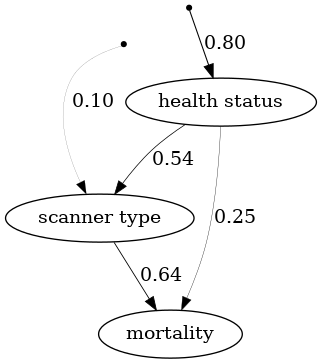

In [268]:
def health_data():
    '''synthetic health data'''
    health_status = np.random.uniform(0, 1)
    scanner_type = np.random.choice([0, 1], 
                                    p=[0.1 if health_status <= 0.1 else 0.7,
                                       0.9 if health_status <= 0.1 else 0.3]) 
    mortality = 1 if health_status <= 0.1 else 0
    return {
        'health status': health_status,
        'scanner type': scanner_type,
        'mortality': mortality
    }

print(health_data())

def build_health_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph: x1->x2->x3, y = f(x1, x2, x3)
    x1 = Node('health status')
    x2 = Node('scanner type', lambda x1: 0.9 if x1 <= 0.1 else 0.3, [x1])
    y  = Node('mortality', lambda x1, x2: x2, 
              [x1, x2], is_target_node=True)
    
    # initialize the values from data
    graph = Graph([x1, x2, y], health_data, 
                 {
                     'health status': 0.1,
                     'scanner type': 1,
                     'mortality': 1
                 }, treat_target_differently=False)
   
    # check the amount of noise
    check_baseline_target(graph)
    return graph

cf = CreditFlow(verbose=False, nruns=1000)
graph = build_health_graph()
cf.run(graph)

dot = cf.credit2dot()
dot.write_png('graph.png')
Image('graph.png')

{'health status': 0.15246858802084695, 'scanner type': 0, 'mortality': 0}
baseline additive noise for scanner type is -0.3
outcome additive noise for scanner type is 0.09999999999999998


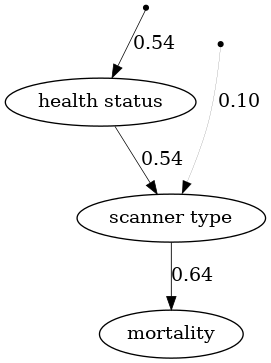

In [269]:
def health_data():
    '''synthetic health data'''
    health_status = np.random.uniform(0, 1)
    scanner_type = np.random.choice([0, 1], 
                                    p=[0.1 if health_status <= 0.1 else 0.7,
                                       0.9 if health_status <= 0.1 else 0.3]) 
    mortality = scanner_type #1 if health_status <= 0.1 else 0
    return {
        'health status': health_status,
        'scanner type': scanner_type,
        'mortality': mortality
    }

print(health_data())

def build_health_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph: x1->x2->x3, y = f(x1, x2, x3)
    x1 = Node('health status')
    x2 = Node('scanner type', lambda x1: 0.9 if x1 <= 0.1 else 0.3, [x1])
    y  = Node('mortality', lambda x1, x2: x2, 
              [x1, x2], is_target_node=True)
    
    # initialize the values from data
    graph = Graph([x1, x2, y], health_data, 
                 {
                     'health status': 0.1,
                     'scanner type': 1,
                     'mortality': 1
                 }, treat_target_differently=False)
   
    # check the amount of noise
    check_baseline_target(graph)
    return graph

cf = CreditFlow(verbose=False, nruns=1000)
graph = build_health_graph()
cf.run(graph)

dot = cf.credit2dot()
dot.write_png('graph.png')
Image('graph.png')

**Observation**: Which graph should we believe? I think we should believe the second one because we are explaining the model, not the reality (health_data).
This means we need to set the baseline for the target variable using the model, not the actual value. Fixing this problem, we have

{'health status': 0.764208285056715, 'scanner type': 0, 'mortality': 0}
baseline additive noise for scanner type is -0.3
outcome additive noise for scanner type is 0.09999999999999998


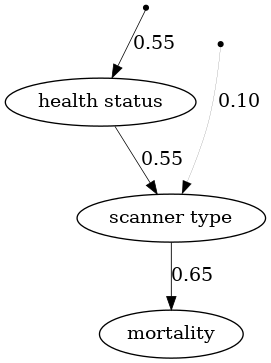

In [270]:
def health_data():
    '''synthetic health data'''
    health_status = np.random.uniform(0, 1)
    scanner_type = np.random.choice([0, 1], 
                                    p=[0.1 if health_status <= 0.1 else 0.7,
                                       0.9 if health_status <= 0.1 else 0.3]) 
    mortality = 1 if health_status <= 0.1 else 0
    return {
        'health status': health_status,
        'scanner type': scanner_type,
        'mortality': mortality
    }

print(health_data())

def build_health_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph: x1->x2->x3, y = f(x1, x2, x3)
    x1 = Node('health status')
    x2 = Node('scanner type', lambda x1: 0.9 if x1 <= 0.1 else 0.3, [x1])
    y  = Node('mortality', lambda x1, x2: x2, 
              [x1, x2], is_target_node=True)
    
    # initialize the values from data
    graph = Graph([x1, x2, y], health_data, 
                 {
                     'health status': 0.1,
                     'scanner type': 1,
                     'mortality': 1
                 })
   
    # check the amount of noise
    check_baseline_target(graph)
    return graph

cf = CreditFlow(verbose=False, nruns=1000)
graph = build_health_graph()
cf.run(graph)

dot = cf.credit2dot()
dot.write_png('graph.png')
Image('graph.png')

# Nonlinear synthetic data with learned models